# Predict Future Sales

Dataset Description : You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.


> 5 csv files
sales_train, test, items, item_categories, shops. <br><br>
Data fields

1.   shop_id - unique identifier of a shop
2.   item_id - unique identifier of a product
3.   item_category_id - unique identifier of item category
4.   item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
5. item_price - current price of an item
6. date - date in format dd/mm/yyyy
7. date_block_num - a consecutive month number, used for convenience
8. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
9. item_name - name of item
10. shop_name - name of shop
11. item_category_name - name of item category
12. ID - an Id that represents a (Shop, Item) tuple within the test set

 **This is a sales demand prediction problem, and the task involves forecasting the total amount of products sold (item_cnt_month) for each shop (shop_id) and product (item_id) combination on a monthly basis.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [ ]:
sales_train = pd.read_csv("/content/drive/MyDrive/csv files/sales_train.csv")
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
items = pd.read_csv("/content/drive/MyDrive/csv files/items.csv")
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
shops = pd.read_csv("/content/drive/MyDrive/csv files/shops.csv")
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
item_category = pd.read_csv("/content/drive/MyDrive/csv files/item_categories.csv")
item_category.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


# Merging all the csv files
 to improve the model performance,
more info will be feed into the model

In [ ]:
sales_train = pd.merge(sales_train, items, on='item_id', how='left')
sales_train = pd.merge(sales_train, shops, on='shop_id', how='left')
sales_train = pd.merge(sales_train, item_category, on='item_category_id', how='left')

In [ ]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


In [ ]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int64  
 2   shop_id             int64  
 3   item_id             int64  
 4   item_price          float64
 5   item_cnt_day        float64
 6   item_name           object 
 7   item_category_id    int64  
 8   shop_name           object 
 9   item_category_name  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 224.0+ MB


In [ ]:
print(sales_train.item_category_name.nunique())
print(sales_train.item_name.nunique())
print(sales_train.shop_name.nunique())

84
21807
60


### Target Encoding (Mean Encoding):
As are categorical features have huge number of unique values doing one-hot-encoding will explode the dimension. so will go for Target encoding -It works by replacing each category with the mean of the target variable (item_cnt_day) for that category. Encoding each category based on its relationship with the target variable.

In [ ]:
sales_train['item_category_name_encoded'] = sales_train.groupby('item_category_name')['item_cnt_day'].transform('mean')
sales_train['shop_name_encoded'] = sales_train.groupby('shop_name')['item_cnt_day'].transform('mean')
sales_train['item_name_encoded'] = sales_train.groupby('item_name')['item_cnt_day'].transform('mean')

In [ ]:
sales_train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,item_category_name_encoded,shop_name_encoded,item_name_encoded
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,1.055067,1.163508,1.000000
1,03.01.2013,0,25,2552,899.0,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,0.994818,1.299918,0.555556
2,05.01.2013,0,25,2552,899.0,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,0.994818,1.299918,0.555556


In [ ]:
sales_train_df = sales_train.drop(['item_category_name','shop_name','item_name'], axis=1)
sales_train_df.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_category_id', 'item_category_name_encoded',
       'shop_name_encoded', 'item_name_encoded'],
      dtype='object')

In [ ]:
sales_train_df['date'] = pd.to_datetime(sales_train_df['date'], format='%d.%m.%Y')

# Preprocessing:

Aggregate the sales_train.csv to monthly sales. sum up the item_cnt_day for each shop_id and item_id at the monthly level (i.e., per date_block_num).<br>
 aggregate item_price

In [ ]:
# Aggregrate sales data
monthly_sales = sales_train_df.groupby(['date_block_num','shop_id','item_id']).agg(
    item_cnt_month = ('item_cnt_day','sum'),
    item_price = ('item_price', 'mean')
).reset_index()

**Feature Engineering:**<br>
**Lag Features**: add lag features such as lag_1, lag_2, etc. These capture the sales of previous months, which are useful for time series forecasting.<br>
**Month**: The month feature captures seasonality effects (i.e., specific trends during certain months).

 Time series forecasting models often use lag features, which capture historical sales data to predict future sales.  create lag features by shifting the item_cnt_month column by 1, 2, 3 months, etc.

In [ ]:
monthly_sales['lag_1'] = monthly_sales.groupby(['shop_id','item_id'])['item_cnt_month'].shift(1)
monthly_sales['lag_2'] = monthly_sales.groupby(['shop_id','item_id'])['item_cnt_month'].shift(2)

Add time-related features: For example, the month of the year can be important for demand forecasting (seasonality).

In [ ]:
monthly_sales['month'] = monthly_sales['date_block_num'] % 12
 # Extract the month of the year (0-11)

In [ ]:
monthly_sales.isna().sum()

,0
date_block_num,0
shop_id,0
item_id,0
item_cnt_month,0
item_price,0
lag_1,424124
lag_2,701617
month,0


New shops/products: Since the list of shops and products changes monthly, we need to handle new shop-item combinations that didn’t appear in previous months. we can use the fillna() method or other strategies to impute missing data.

In [ ]:
monthly_sales.fillna(0, inplace=True)

In [ ]:
monthly_sales.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,lag_1,lag_2,month
0,0,0,32,6.0,221.0,0.0,0.0,0
1,0,0,33,3.0,347.0,0.0,0.0,0
2,0,0,35,1.0,247.0,0.0,0.0,0
3,0,0,43,1.0,221.0,0.0,0.0,0
4,0,0,51,2.0,128.5,0.0,0.0,0


In [ ]:
# Prepare the feature and target
features = ['lag_1','lag_2','month','item_price'] + list(sales_train_df.columns[sales_train_df.columns.str.contains('item_name_encoded|item_category_name_encoded|shop_name_encoded')])
target = 'item_cnt_month'

In [ ]:
features

['lag_1',
 'lag_2',
 'month',
 'item_price',
 'item_category_name_encoded',
 'shop_name_encoded',
 'item_name_encoded']

In [ ]:
train_data = monthly_sales.merge(sales_train_df[['date_block_num','shop_id','item_id','shop_name_encoded','item_category_name_encoded','item_name_encoded','item_price']], on=['date_block_num','shop_id','item_id','item_price'], how='left').fillna(0)

In [ ]:
train_data.head(2)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,lag_1,lag_2,month,shop_name_encoded,item_category_name_encoded,item_name_encoded
0,0,0,32,6.0,221.0,0.0,0.0,0,1.187481,1.123118,1.110403
1,0,0,32,6.0,221.0,0.0,0.0,0,1.187481,1.123118,1.110403


# Analyzing and Visualizing sales data
its a sales demand prediction — visualization could help identify which products and item categories are selling well in each shop. This information can be valuable for sellers to plan their inventory and future stock levels.
we analyze historical data to find which shop is selling which products and which item categories the most. This will provide actionable insights for sellers to understand demand and plan accordingly.


In [ ]:
# Step 1: Aggregate total sales by shop, item, and item category
sales_by_shop_item = (
    sales_train
    .groupby(['shop_id', 'item_id', 'item_category_id'], as_index=False)
    .agg(total_sales=('item_cnt_day', 'sum'))
)

# Step 2: Merge with item and item category details
sales_by_shop_item = (
    sales_by_shop_item
    .merge(items[['item_id', 'item_name']], on='item_id', how='inner')
    .merge(item_category[['item_category_id','item_category_name']], on='item_category_id', how='inner')
)

# Step 3: Sort by total sales
sales_by_shop_item = sales_by_shop_item.sort_values(by='total_sales', ascending=False)

sales_by_shop_item.head()


,shop_id,item_id,item_category_id,total_sales,item_name,item_category_name
230429,31,20949,71,19934.0,Фирменный пакет майка 1С Интерес белый (34*42)...,"Подарки - Сумки, Альбомы, Коврики д/мыши"
166003,25,20949,71,14343.0,Фирменный пакет майка 1С Интерес белый (34*42)...,"Подарки - Сумки, Альбомы, Коврики д/мыши"
198879,28,20949,71,13458.0,Фирменный пакет майка 1С Интерес белый (34*42)...,"Подарки - Сумки, Альбомы, Коврики д/мыши"
382373,54,20949,71,12323.0,Фирменный пакет майка 1С Интерес белый (34*42)...,"Подарки - Сумки, Альбомы, Коврики д/мыши"
286959,42,20949,71,10514.0,Фирменный пакет майка 1С Интерес белый (34*42)...,"Подарки - Сумки, Альбомы, Коврики д/мыши"


<ipython-input-27-9081054b52db>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_sales', y='item_name', data=shop_sales, palette='viridis')


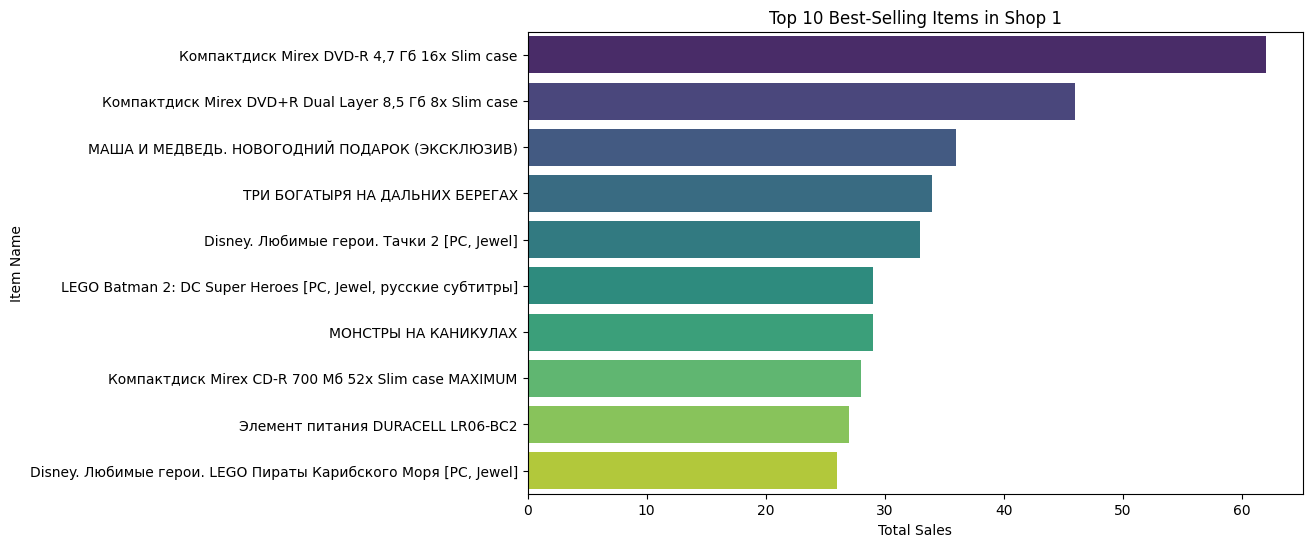

In [ ]:
# Plot the top 10 best-selling items in a particular shop (e.g., shop_id = 1)
shop_sales = sales_by_shop_item[sales_by_shop_item['shop_id']==1].head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='total_sales', y='item_name', data=shop_sales, palette='viridis')
plt.title('Top 10 Best-Selling Items in Shop 1')
plt.xlabel('Total Sales')
plt.ylabel('Item Name')
plt.show()

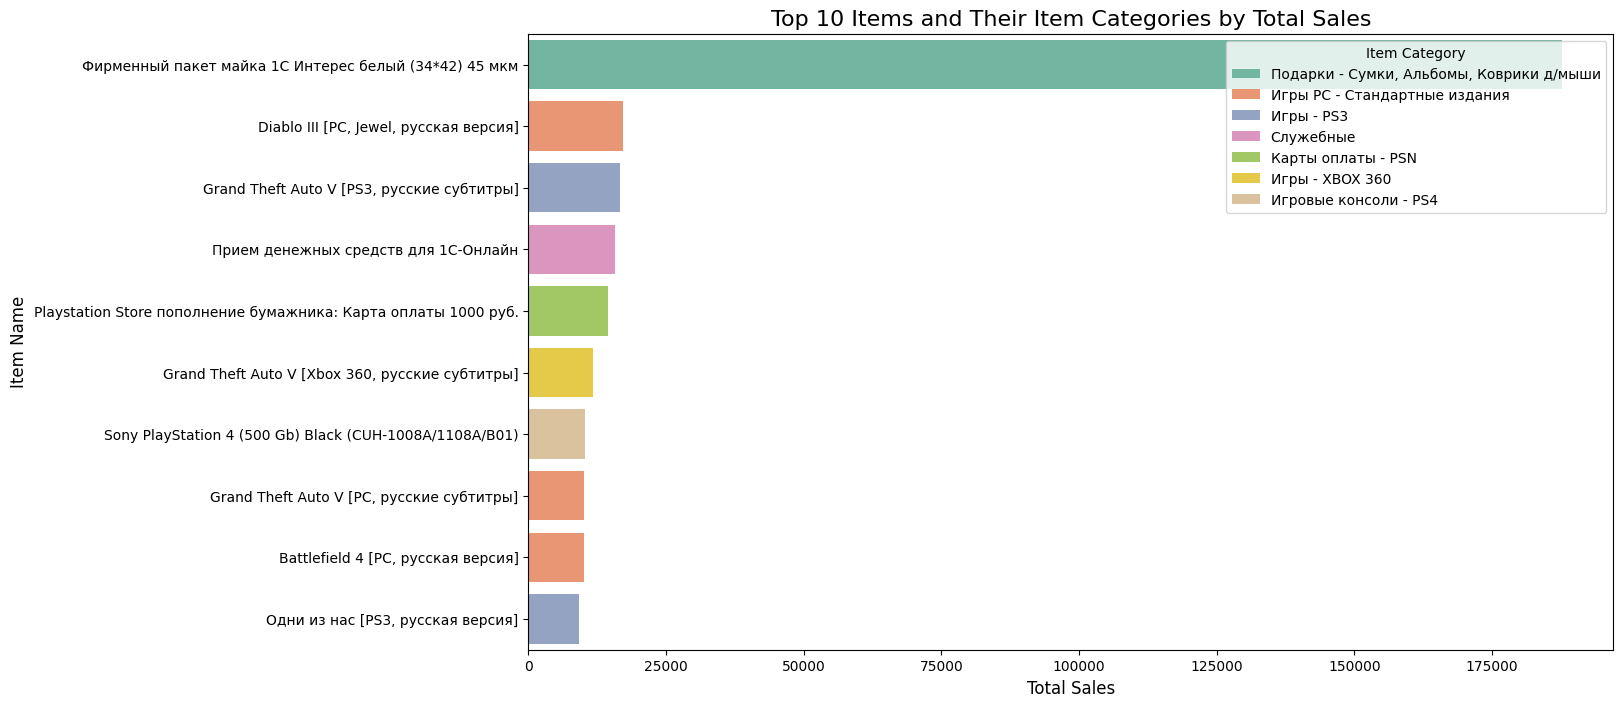

In [ ]:

# Aggregate total sales by item and item category
item_category_sales = sales_by_shop_item.groupby(['item_category_name', 'item_name']).agg(
    total_sales=('total_sales', 'sum')
).reset_index()

# Sort by total sales and get the top 10 items
top_10_items = item_category_sales.sort_values(by='total_sales', ascending=False).head(10)

plt.figure(figsize=(14, 8))

#grouped bar plot for the top 10 items
sns.barplot(x='total_sales', y='item_name', hue='item_category_name', data=top_10_items, palette='Set2')


plt.title('Top 10 Items and Their Item Categories by Total Sales', fontsize=16)
plt.xlabel('Total Sales', fontsize=12)
plt.ylabel('Item Name', fontsize=12)
plt.legend(title='Item Category', loc='upper right')

plt.show()


In [ ]:
# Aggregate sales by shop and item category
sales_by_shop_category = sales_train.groupby(['shop_id', 'item_category_id']).agg(
    total_sales_category=('item_cnt_day', 'sum')
).reset_index()

# Merge with item categories for readability
sales_by_shop_category = sales_by_shop_category.merge(item_category, on='item_category_id', how='left')

# Sort by total sales to see which categories are selling the most in each shop
sales_by_shop_category = sales_by_shop_category.sort_values(by='total_sales_category', ascending=False)

sales_by_shop_category.head()


,shop_id,item_category_id,total_sales_category,item_category_name
1717,31,40,76069.0,Кино - DVD
1352,25,40,45176.0,Кино - DVD
2988,54,40,44904.0,Кино - DVD
3122,57,40,44589.0,Кино - DVD
1537,28,40,38588.0,Кино - DVD


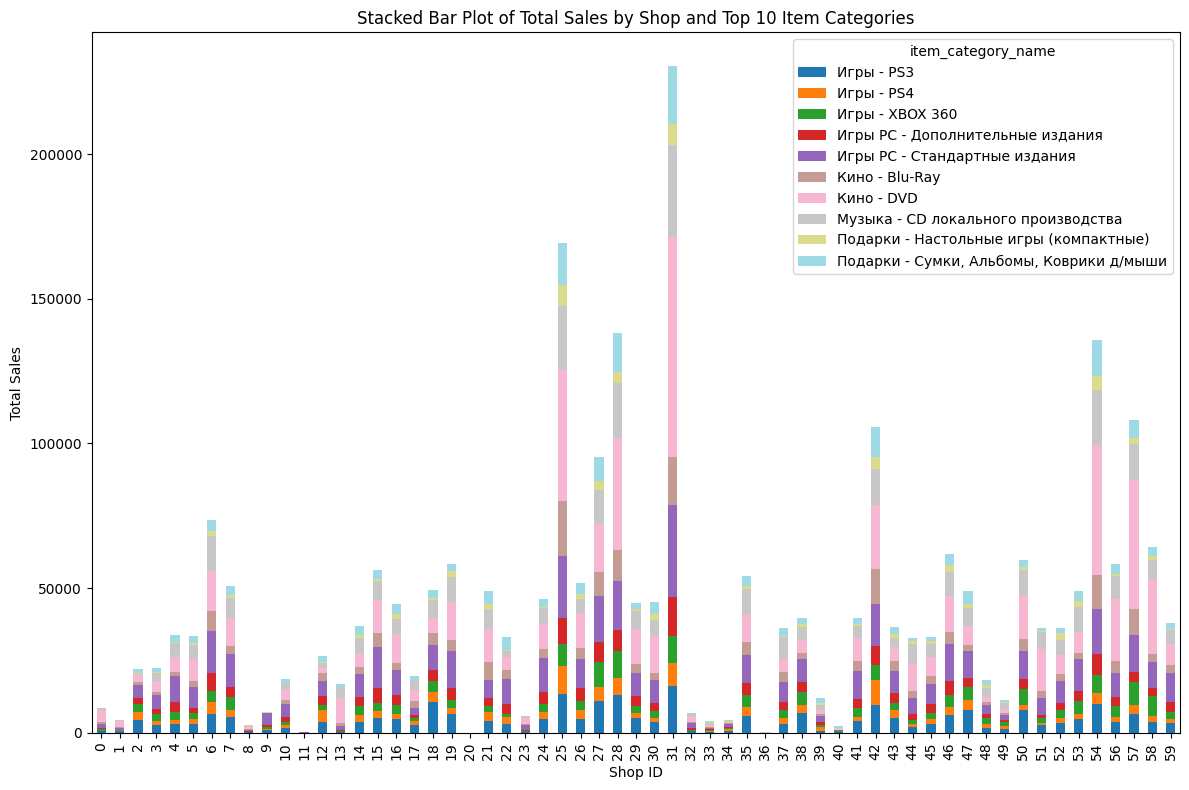

In [ ]:
# Step 1: Aggregate the total sales for each item category across all shops
total_sales_by_category = sales_by_shop_category.groupby('item_category_name').agg(
    total_sales_category=('total_sales_category', 'sum')
).reset_index()

# Step 2: Sort the item categories by total sales and select the top 10
top_10_categories = total_sales_by_category.sort_values(by='total_sales_category', ascending=False).head(10)

# Step 3: Filter the sales_by_shop_category data to include only the top 10 categories
sales_by_shop_category_top_10 = sales_by_shop_category[sales_by_shop_category['item_category_name'].isin(top_10_categories['item_category_name'])]

# Step 4: Pivot the data to get total sales by shop and top 10 item categories
sales_pivot = sales_by_shop_category_top_10.pivot_table(
    index='shop_id',
    columns='item_category_name',
    values='total_sales_category',
    aggfunc='sum'
)

# Step 5: Plot the stacked bar plot
sales_pivot.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')

plt.title('Stacked Bar Plot of Total Sales by Shop and Top 10 Item Categories')
plt.xlabel('Shop ID')
plt.ylabel('Total Sales')

plt.tight_layout()
plt.show()


# Train_test_split

In [ ]:
X = train_data[features]
y = train_data[target]

In [ ]:
# Train-test split (time-based split, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
X_train.shape, y_train.shape

((2084490, 7), (2084490,))

In [ ]:
model = RandomForestRegressor(n_estimators=50, random_state=97,
                  min_samples_split=10, min_samples_leaf=5, bootstrap=True)

In [ ]:
model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=5, min_samples_split=10, n_estimators=50,
                      random_state=97)

In [ ]:
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 2.6708900877487523


In [ ]:
test_data = pd.read_csv("/content/drive/MyDrive/csv files/test.csv")
test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
ID = test_data['ID']

In [ ]:
merged = items.merge(item_category, on='item_category_id',how='left')
merged.head(2)

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,Программы - Для дома и офиса (Цифра)


In [ ]:
test_data = test_data.merge(merged, on='item_id', how='left')
test_data = test_data.merge(shops, on='shop_id', how='left')

In [ ]:
test_data.head(2)

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад"""
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад"""


## Applying same preprocessing steps for the test data
1.	Use the same feature engineering steps for test data as for the training data, ensuring that lag features, item prices, and month features are included.
2.	Missing values: Handle any missing data (for lag features and merged columns) by filling them with 0 (or a reasonable default).
3.	Test data predictions: Ensure that  test data follows the same transformations as the training data before making predictions.


**leveraging train data (slaes_train_df, monthly_sales) to help generate features for the test data**<br>
using the train data to prepare or supplement test data to ensure consistency and provide necessary information that the model will use during prediction. For example, item_price is not present in the test data, but we can derive it from the training data where we have this information. This step is a form of feature engineering to ensure the test set is consistent with what the model has learned during training.

In [ ]:
item_prices = sales_train_df.groupby(['shop_id','item_id'])['item_price'].mean().reset_index()
test_data = test_data.merge(item_prices, on=['shop_id','item_id'], how='left')

In [ ]:
test_data.head(1)

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name,item_price
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",1633.692308


Since the test data represents future data that we want to predict, we set the date_block_num of the test data to last_month + 1. This way, the model is essentially predicting sales for the next time period based on the features derived from previous periods.

In [ ]:
# gets the latest month in the train data by finding the maximum value of date_block_num.
last_month = monthly_sales['date_block_num'].max() # the training data
test_data['date_block_num'] = last_month + 1 # Set to next month
test_data['month'] = test_data['date_block_num'] % 12  # Extract month from date_block_num

In [ ]:
monthly_sales.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_price',
       'lag_1', 'lag_2', 'month'],
      dtype='object')

In [ ]:
test_data = test_data.merge(monthly_sales[['shop_id', 'item_id', 'item_cnt_month', 'date_block_num']],
                             how='left', on=['shop_id', 'item_id', 'date_block_num'])


In [ ]:
test_data.columns

Index(['ID', 'shop_id', 'item_id', 'item_name', 'item_category_id',
       'item_category_name', 'shop_name', 'item_price'],
      dtype='object')

In [ ]:
test_data['lag_1'] = test_data.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(1)
test_data['lag_2'] = test_data.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(2)


In [ ]:
test_data = test_data.fillna(0)


In [ ]:
# calculate the mean values for the training data
shop_name_mean = sales_train.groupby('shop_name')['item_cnt_day'].mean()
item_category_name_mean = sales_train.groupby('item_category_name')['item_cnt_day'].mean()
item_name_mean = sales_train.groupby('item_name')['item_cnt_day'].mean()

In [ ]:
# apply these mean values to the test data
test_data['shop_name_encoded'] = test_data['shop_name'].map(shop_name_mean)
test_data['item_category_name_encoded'] = test_data['item_category_name'].map(item_category_name_mean)
test_data['item_name_encoded'] = test_data['item_name'].map(item_name_mean)

In [ ]:
# for any NaN values fill them with the overall mean or a default value
test_data['shop_name_encoded'] = test_data['shop_name_encoded'].fillna(shop_name_mean.mean())
test_data['item_category_name_encoded']= test_data['item_category_name_encoded'].fillna(item_category_name_mean.mean())
test_data['item_name_encoded']= test_data['item_name_encoded'].fillna(item_name_mean.mean())

In [ ]:
# Add the same features that were used in training
test_features = ['lag_1', 'lag_2', 'month', 'item_price'] + list(sales_train_df.columns[sales_train_df.columns.str.contains('item_name_encoded|item_category_name_encoded|shop_name_encoded')])
test_data = test_data[test_features].fillna(0)

In [ ]:
test_data.head(2)

,lag_1,lag_2,month,item_price,item_category_name_encoded,shop_name_encoded,item_name_encoded
0,0.0,0.0,10,1633.692308,1.224129,1.12004,1.166208
1,0.0,0.0,10,0.000000,1.026521,1.12004,1.091992


In [ ]:
test_predictions = model.predict(test_data)
test_predictions = np.round(test_predictions)

In [ ]:
# Create the final output with the 'ID' and predicted sales
test_data_output = pd.DataFrame({
    'ID': ID,
    'predicted_item_cnt_month': test_predictions
})
test_data_output.head(10)

,ID,predicted_item_cnt_month
0,0,2.0
1,1,2.0
2,2,1.0
3,3,2.0
4,4,1.0
5,5,2.0
6,6,3.0
7,7,2.0
8,8,4.0
9,9,2.0
